In [1]:
import requests
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# CSV files to load
opioid_deaths_to_load = Path('Data/opioid_death_counts.csv')
employment_data_to_load = Path('Data/combined_employment_data.csv')
education_data_to_load = Path('Data/combined_education_data.csv')
income_data_to_load = Path('Data/combined_income_data.csv')
family_size_data_to_load = Path('Data/combined_family_size_data.csv')

# read files and store into Pandas DataFrames
opioid_csv = pd.read_csv(opioid_deaths_to_load, index_col = 0)
employment_csv = pd.read_csv(employment_data_to_load, index_col = 0)
education_csv = pd.read_csv(education_data_to_load, index_col = 0)
income_csv = pd.read_csv(income_data_to_load, index_col = 0)
family_size_csv = pd.read_csv(family_size_data_to_load, index_col = 0)

# merge csv to master file
demographic_vs_opioid_df = pd.merge(employment_csv, opioid_csv, on=['State', 'Year'], how='left')
demographic_vs_opioid_df = pd.merge(demographic_vs_opioid_df, education_csv,  on=['State', 'Year'], how='left')
demographic_vs_opioid_df = pd.merge(demographic_vs_opioid_df, income_csv, on=['State', 'Year'], how='left')
demographic_vs_opioid_df = pd.merge(demographic_vs_opioid_df, family_size_csv, on=['State', 'Year'], how='left')

demographic_vs_opioid_df

,Year,State,State ID_x,Geography,Total Eligible for Employment,Total in Labor Force,Total Not in Labor Force,Total in Civilian Labor Force,Total Employed in Civilian Labor Force,Total Unemployed in Civilian Labor Force,...,Total Surveyed,Geo ID,State ID_y,Median Household Income (in Inflation-Adjusted Dollars),Estimated Total Household Type(Including Living Alone),Estimated Total Family Households(Married Couples),Estimated Total Family Households(Male Householder No Spouse),Estimated Total Family Households(Female Householder No Spouse),Estimated Total Family Household(Nonfamily Households),Estimated Total Family Household(Householder Living Alone)
0,2022,Alabama,1,0400000US01,4093740,2398213,1695527,2381733,2278494,103239,...,3474924,0400000US01,1.0,59674.0,2016448,941596,90528,276864,707460,612711
1,2022,Alaska,2,0400000US02,575934,386093,189841,361685,345201,16484,...,489218,0400000US02,2.0,88121.0,274574,129511,17440,28838,98785,76356
2,2022,Arizona,4,0400000US04,5961733,3619698,2342035,3595613,3441676,153937,...,5053656,0400000US04,4.0,74568.0,2850377,1332270,174058,337202,1006847,775093
3,2022,Arkansas,5,0400000US05,2430600,1404190,1026410,1397919,1335560,62359,...,2057624,0400000US05,5.0,55432.0,1216207,572596,57647,147690,438274,374526
4,2022,California,6,0400000US06,31552708,20174168,11378540,20003799,18942977,1060822,...,26866773,0400000US06,6.0,91551.0,13550586,6516115,870396,1764293,4399782,3296939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2017,Maine,23,0400000US23,1114189,702420,411769,700979,671486,29493,...,971740,0400000US23,23.0,56277.0,540959,263878,21476,44752,210853,164809
251,2017,Maryland,24,0400000US24,4855374,3294443,1560931,3268601,3098182,170419,...,4167604,0400000US24,24.0,80776.0,2207343,1052297,104699,312834,737513,605688
252,2017,Massachusetts,25,0400000US25,5660731,3776331,1884400,3771625,3599534,172091,...,4788573,0400000US25,25.0,77385.0,2604954,1223401,111658,317155,952740,745478
253,2017,Michigan,26,0400000US26,8052502,4949724,3102778,4945632,4654612,291020,...,6819310,0400000US26,26.0,54909.0,3930017,1856750,189558,471695,1412014,1162080


In [3]:
# set up masterfile
masterfile_data_summary = demographic_vs_opioid_df [[
    'Year',
    'State',
    'Total Opioid Deaths',
    'Median Household Income (in Inflation-Adjusted Dollars)',
    'Total in Labor Force',
    'Total Unemployed in Civilian Labor Force',
    'Total Surveyed',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Estimated Total Household Type(Including Living Alone)',
    'Estimated Total Family Households(Married Couples)',
    'Estimated Total Family Households(Male Householder No Spouse)',
    'Estimated Total Family Households(Female Householder No Spouse)',
    'Estimated Total Family Household(Nonfamily Households)',
    'Estimated Total Family Household(Householder Living Alone)'
]]

# demographic columns grouped with headers
columns = [
    ('Year/State','Year'),
    ('Year/State','State'),
    ('Opioid Data', 'Total Opioid Deaths'),
    ('Income Data', 'Median Household Income (in Inflation–Adjusted Dollars)'),
    ('Employment Data', 'Total in Labor Force'),
    ('Employment Data', 'Total Unemployed in Civilian Labor Force'),
    ('Education Data', 'Total Surveyed'),
    ('Education Data', 'No High School Degree'),
    ('Education Data', 'High School Diploma or GED'),
    ('Education Data', 'College Degree or greater'),
    ('Family Size Data', 'Estimated Total Household Type(Including Living Alone)'),
    ('Family Size Data', 'Estimated Total Family Households(Married Couples)'),
    ('Family Size Data', 'Estimated Total Family Households(Male Householder No Spouse)'),
    ('Family Size Data', 'Estimated Total Family Households(Female Householder No Spouse)'),
    ('Family Size Data', 'Estimated Total Family Household(Nonfamily Households)'),
    ('Family Size Data', 'Estimated Total Family Household(Householder Living Alone)')
]
# implement multi index column headers
multi_index = pd.MultiIndex.from_tuples(columns)
masterfile_data_summary.columns = multi_index

# csv output
masterfile_data_summary.to_csv('Data/masterfile_data.csv')

masterfile_data_summary

Year/State                        Opioid Data  \
          Year          State Total Opioid Deaths   
0         2022        Alabama         1015.777778   
1         2022         Alaska          185.583333   
2         2022        Arizona         1983.250000   
3         2022       Arkansas          387.833333   
4         2022     California         7705.583333   
..         ...            ...                 ...   
250       2017          Maine          322.916667   
251       2017       Maryland         2017.500000   
252       2017  Massachusetts         1911.333333   
253       2017       Michigan            0.000000   
254       2017      Minnesota            0.000000   

                                                Income Data  \
    Median Household Income (in Inflation–Adjusted Dollars)   
0                                              59674.0        
1                                              88121.0        
2                                              74568.0        
3                                              55432.0        
4                                              91551.0        
..                                                 ...        
250                                            56277.0        
251                                            80776.0        
252                                            77385.0        
253                                            54909.0        
254                                            68388.0        

         Employment Data                                           \
    Total in Labor Force Total Unemployed in Civilian Labor Force   
0                2398213                                   103239   
1                 386093                                    16484   
2                3619698                                   153937   
3                1404190                                    62359   
4               20174168                                  1060822   
..                   ...                                      ...   
250               702420                                    29493   
251              3294443                                   170419   
252              3776331                                   172091   
253              4949724                                   291020   
254              3073117                                   110757   

    Education Data                                                   \
    Total Surveyed No High School Degree High School Diploma or GED   
0          3474924                389297                    1773299   
1           489218                 32669                     258533   
2          5053656                548248                    2363882   
3          2057624                223437                    1143746   
4         26866773               4115683                   10699709   
..             ...                   ...                        ...   
250         971740                 74787                     485132   
251        4167604                420009                    1809636   
252        4788573                442458                    1906744   
253        6819310                619966                    3563864   
254        3778416                261634                    1727896   

                               \
    College Degree or greater   
0                     1312328   
1                      198016   
2                     2141526   
3                      690441   
4                    12051381   
..                        ...   
250                    411821   
251                   1937959   
252                   2439371   
253                   2635480   
254                   1788886   

                                          Family Size Data  \
    Estimated Total Household Type(Including Living Alone)   
0                                              2016448       
1                                               274574  

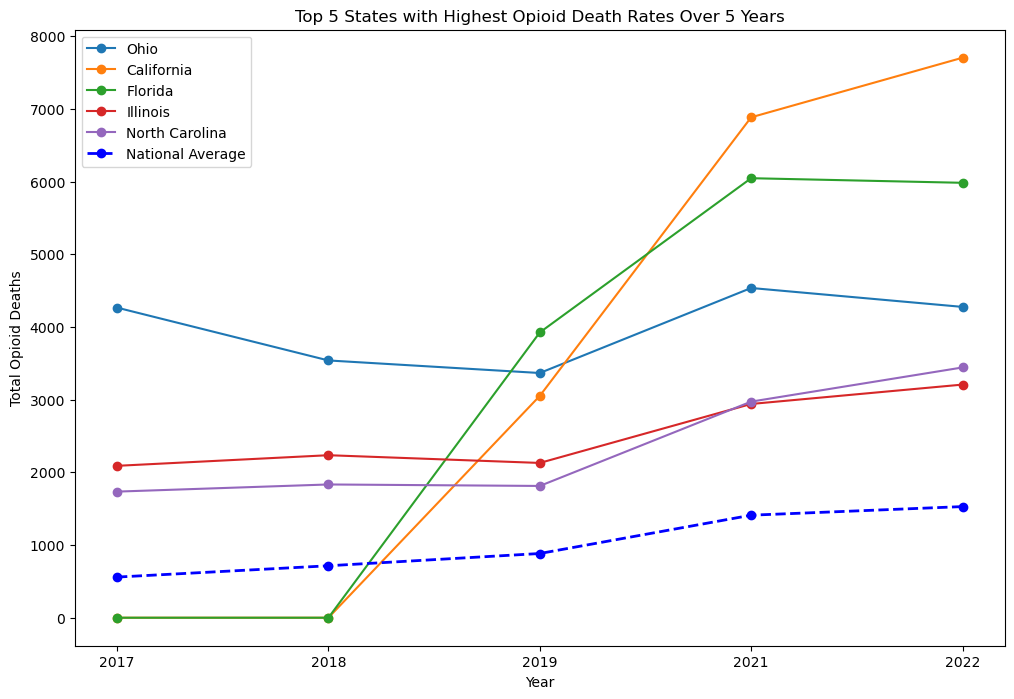

In [4]:
# convert year to string

demographic_vs_opioid_df['Year'] = demographic_vs_opioid_df['Year'].astype(str)
demographic_vs_opioid_df = demographic_vs_opioid_df.sort_values(by = 'Year', ascending = True)

# national average
national_average_per_year = demographic_vs_opioid_df.groupby('Year')['Total Opioid Deaths'].mean()

top_5_states = demographic_vs_opioid_df.groupby('State')['Total Opioid Deaths'].sum().nlargest(5).index

top_5_data = demographic_vs_opioid_df[demographic_vs_opioid_df['State'].isin(top_5_states)]

plt.figure(figsize=(12,8))

for state in top_5_states:
    state_data = top_5_data[top_5_data['State'] == state]
    plt.plot(state_data['Year'], state_data['Total Opioid Deaths'], marker = 'o', label = state)

plt.plot(national_average_per_year.index, national_average_per_year.values, color = 'blue', linestyle = '--', linewidth = 2, marker = 'o', label = 'National Average')

plt.xlabel('Year')
plt.ylabel('Total Opioid Deaths')
plt.title('Top 5 States with Highest Opioid Death Rates Over 5 Years')
plt.legend()

plt.show()

importing Jupyter notebook from Unemployment_Notebook.ipynb

Contribution Ratio Indicators:

Ratio > 1: Indicates that unemployment is disproportionately higher relative to opioid related deaths in that state.
Ratio = 1: Indicates a balance between contributions to unemployment and opioid deaths.
Ratio < 1: Indicates that suggesting that unemployment is disproportionately lower relative to opioid related deaths in that state.



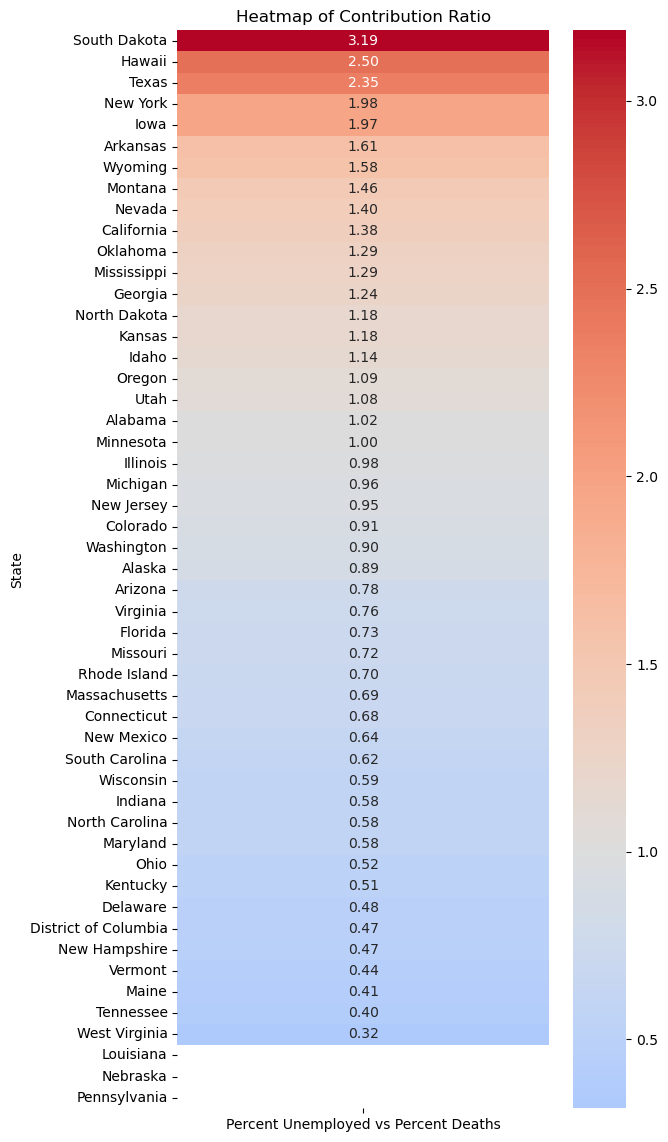

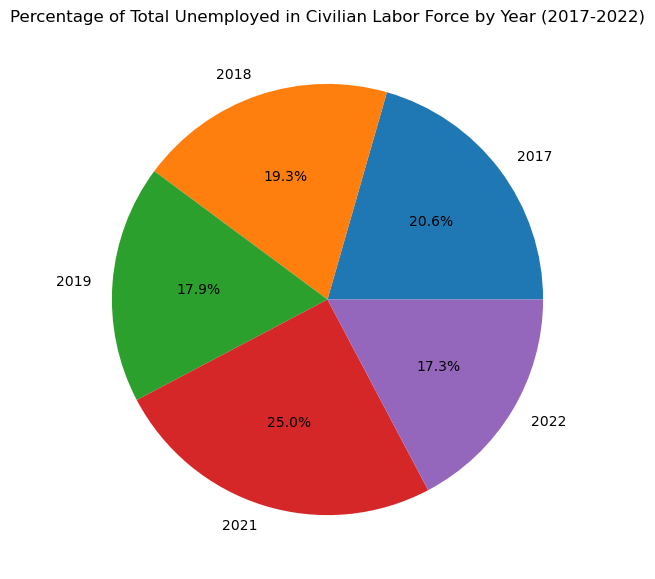

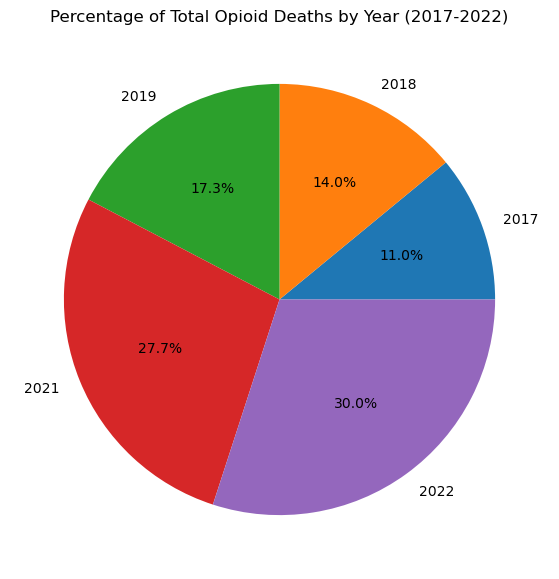

In [5]:
import import_ipynb
import Unemployment_Notebook

importing Jupyter notebook from Education_Notebook.ipynb


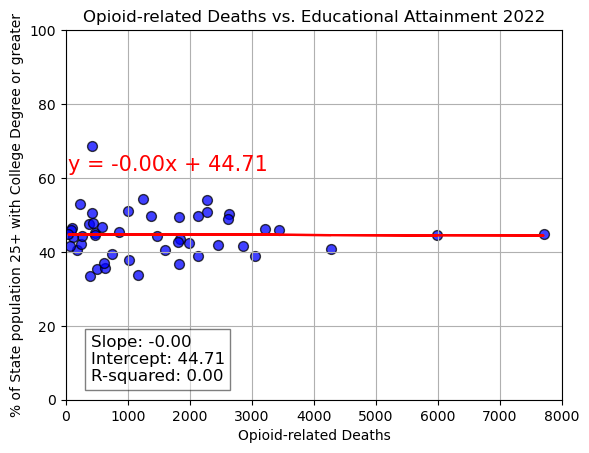

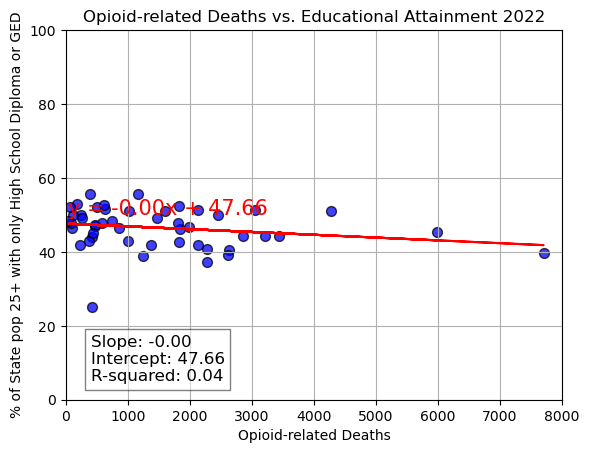

In [6]:
import import_ipynb
import Education_Notebook

importing Jupyter notebook from Family_Size_Notebook.ipynb
2022 Family Size URL: https://api.census.gov/data/2022/acs/acs1?get=NAME,group(B11001)&for=state:01,02,04,05,06,08,09,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56&key=7777ffa764c28bf2199fbc37bc1a516b6a535250

2021 Family Size URL: https://api.census.gov/data/2021/acs/acs1?get=NAME,group(B11001)&for=state:01,02,04,05,06,08,09,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56&key=7777ffa764c28bf2199fbc37bc1a516b6a535250

2019 Family Size URL: https://api.census.gov/data/2019/acs/acs1?get=NAME,group(B11001)&for=state:01,02,04,05,06,08,09,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56&key=7777ffa764c28bf2199fbc37bc1a516b6a535250

2018 Family Size URL: https://api.census.gov/data/201

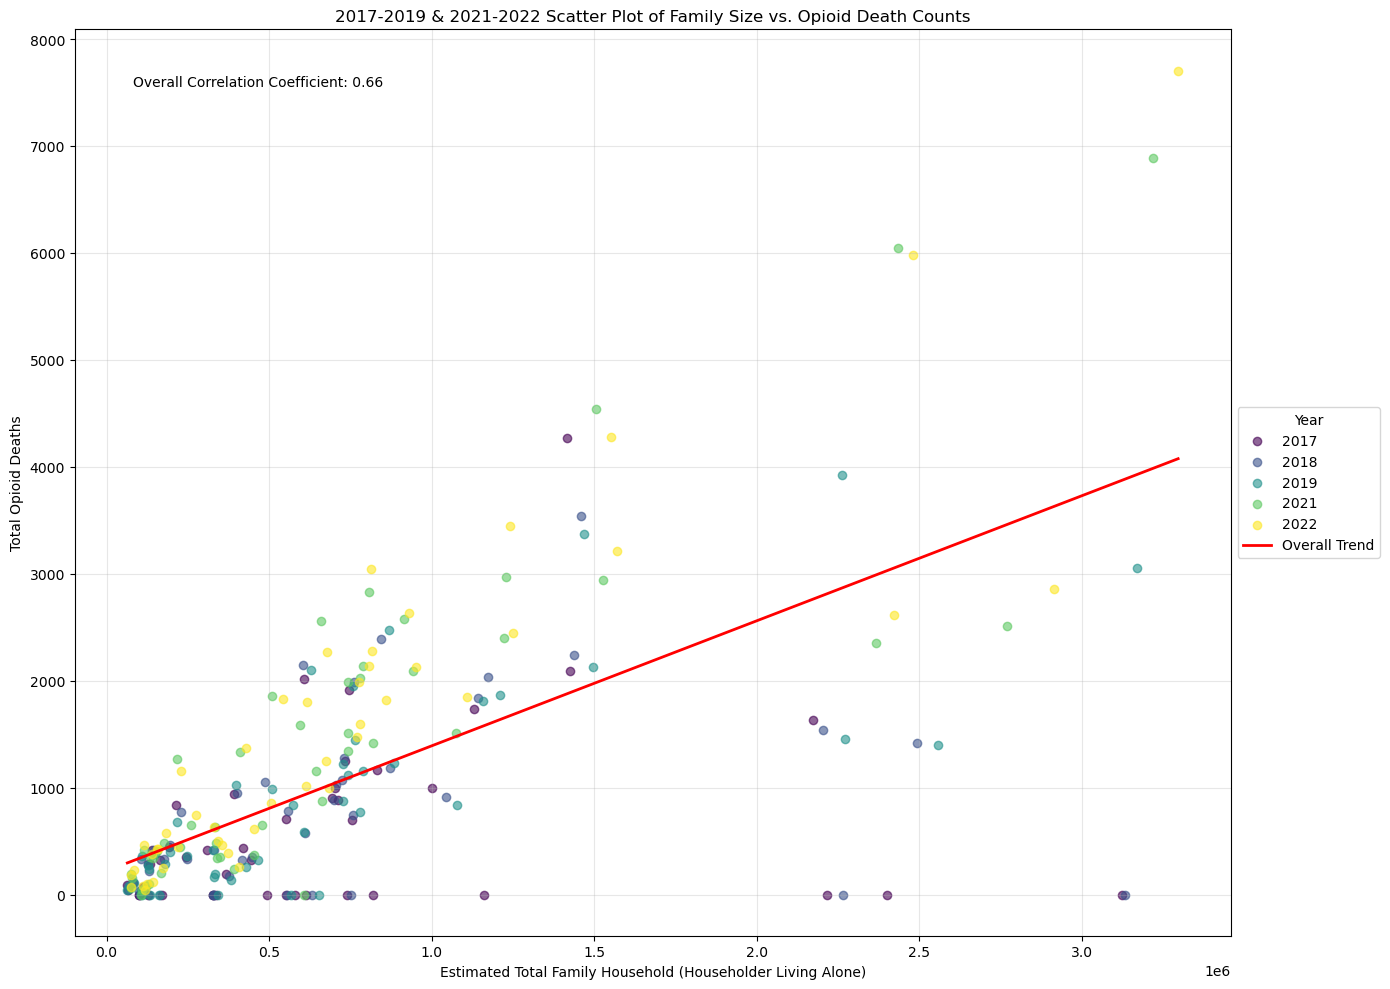

                             OLS Regression Results                            
Dep. Variable:     Total Opioid Deaths   R-squared:                       0.440
Model:                             OLS   Adj. R-squared:                  0.437
Method:                  Least Squares   F-statistic:                     186.8
Date:                 Mon, 19 Aug 2024   Prob (F-statistic):           8.89e-32
Time:                         11:55:16   Log-Likelihood:                -1977.2
No. Observations:                  240   AIC:                             3958.
Df Residuals:                      238   BIC:                             3965.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

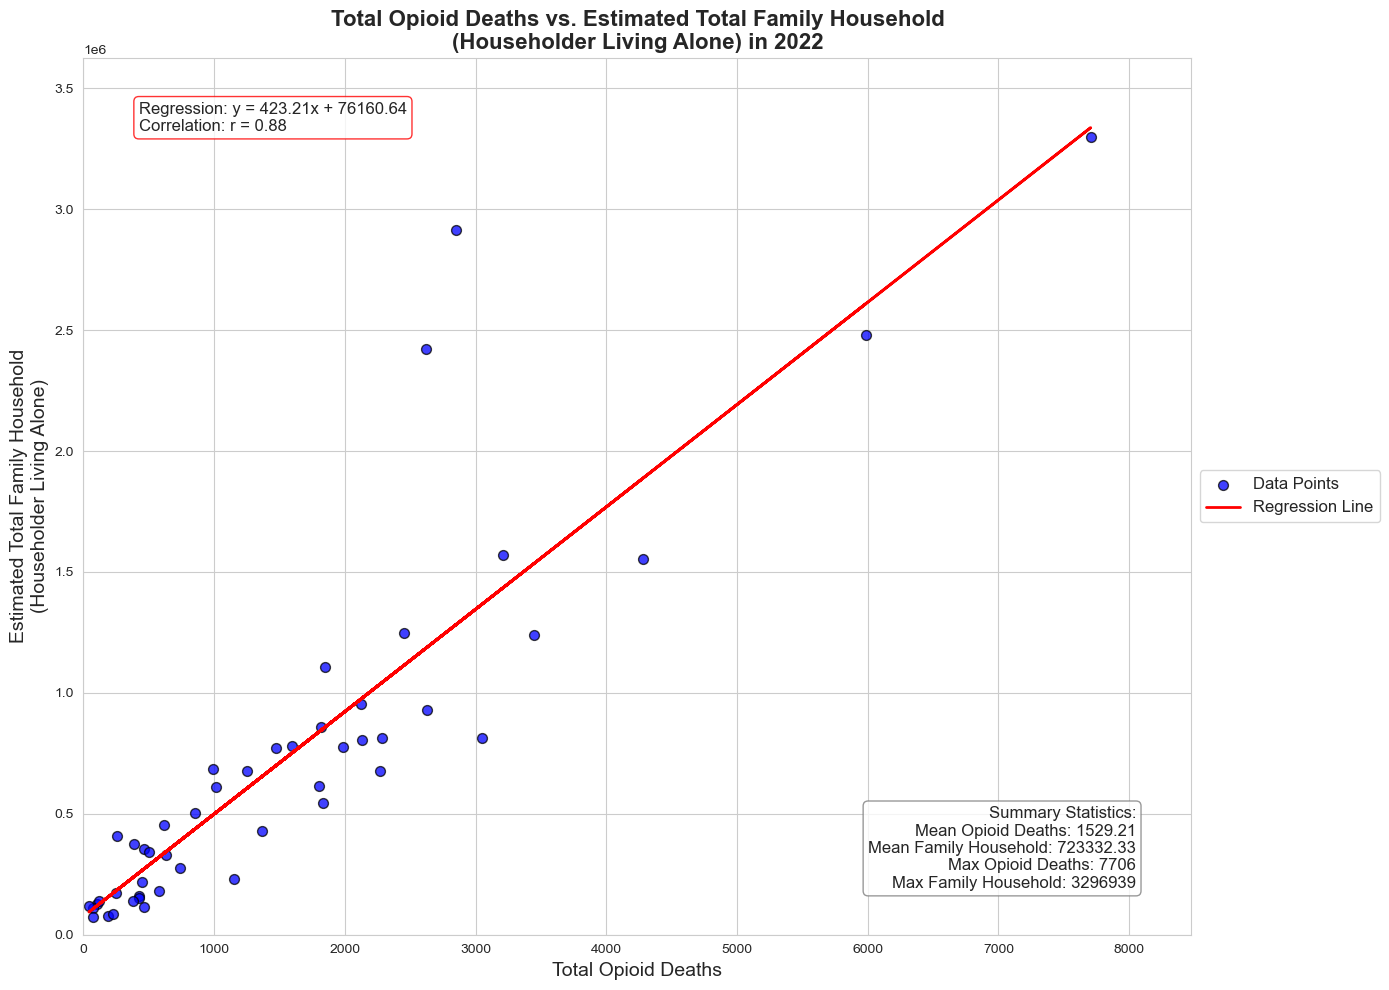


Detailed Summary Statistics:
       Total Opioid Deaths  \
count            48.000000   
mean           1529.211516   
std            1550.146827   
min              41.750000   
25%             424.583333   
50%            1085.305556   
75%            2167.979167   
max            7705.583333   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        7.233323e+05           
std                                         7.423948e+05           
min                                         7.405400e+04           
25%                                         1.795890e+05           
50%                                         5.241070e+05           
75%                                         8.261055e+05           
max                                         3.296939e+06           


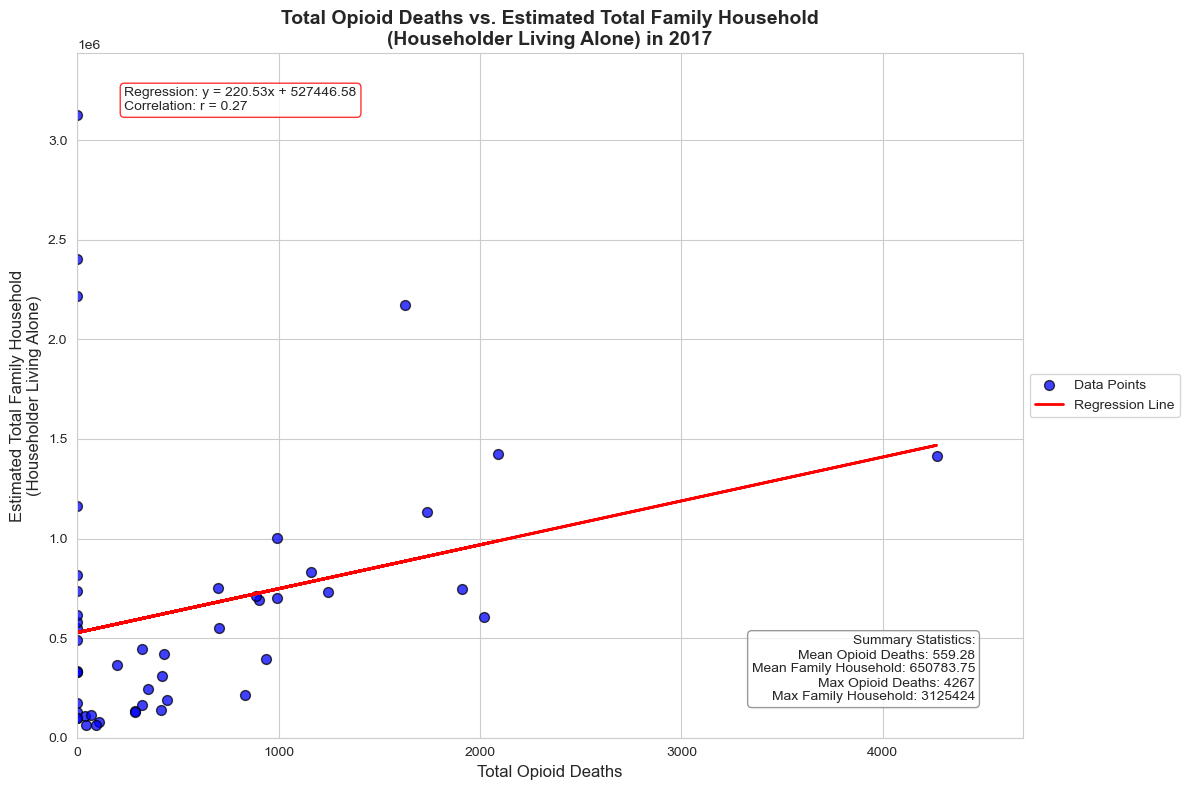


Detailed Summary Statistics for 2017:
       Total Opioid Deaths  \
count            48.000000   
mean            559.282035   
std             815.848308   
min               0.000000   
25%               0.000000   
50%             287.583333   
75%             890.497024   
max            4266.750000   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        6.507838e+05           
std                                         6.669479e+05           
min                                         6.350400e+04           
25%                                         1.699645e+05           
50%                                         4.685085e+05           
75%                                         7.476298e+05           
max                                         3.125424e+06           




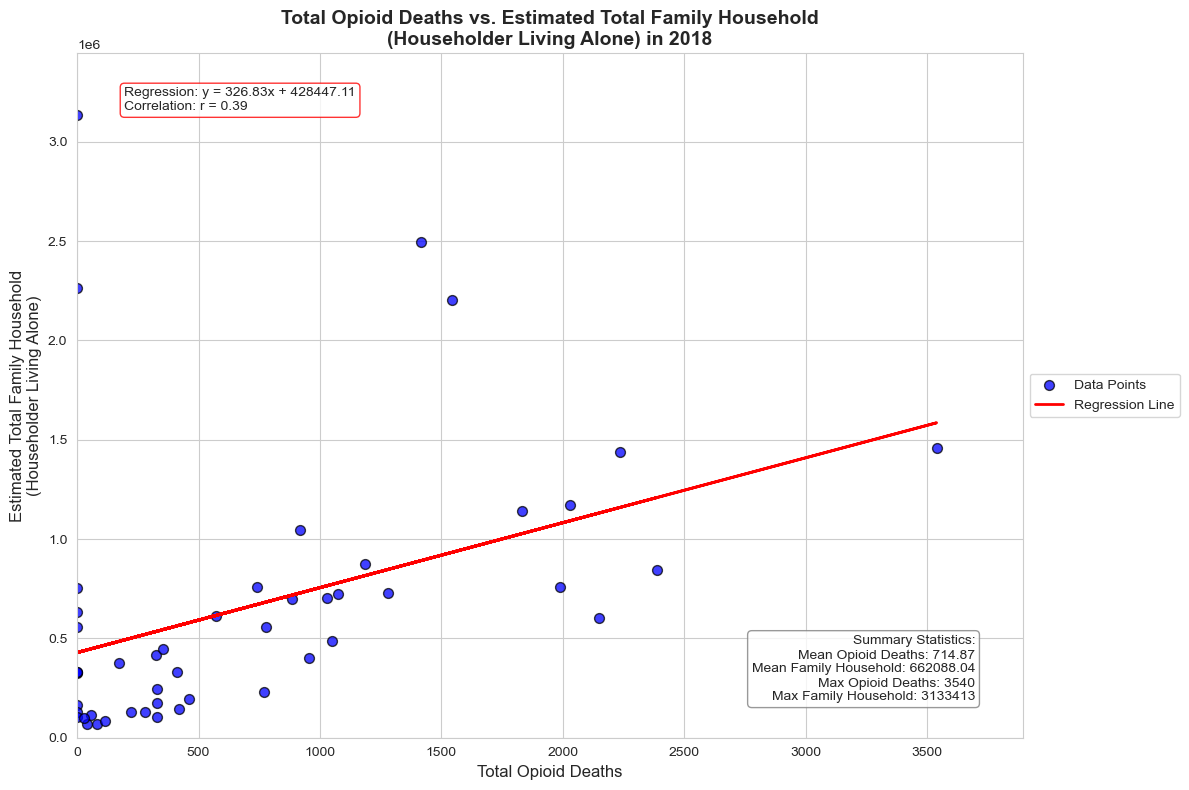


Detailed Summary Statistics for 2018:
       Total Opioid Deaths  \
count            48.000000   
mean            714.867436   
std             817.515822   
min               0.000000   
25%              38.437500   
50%             383.000000   
75%            1054.218182   
max            3540.000000   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        6.620880e+05           
std                                         6.783278e+05           
min                                         6.625300e+04           
25%                                         1.723935e+05           
50%                                         4.674500e+05           
75%                                         7.590068e+05           
max                                         3.133413e+06           




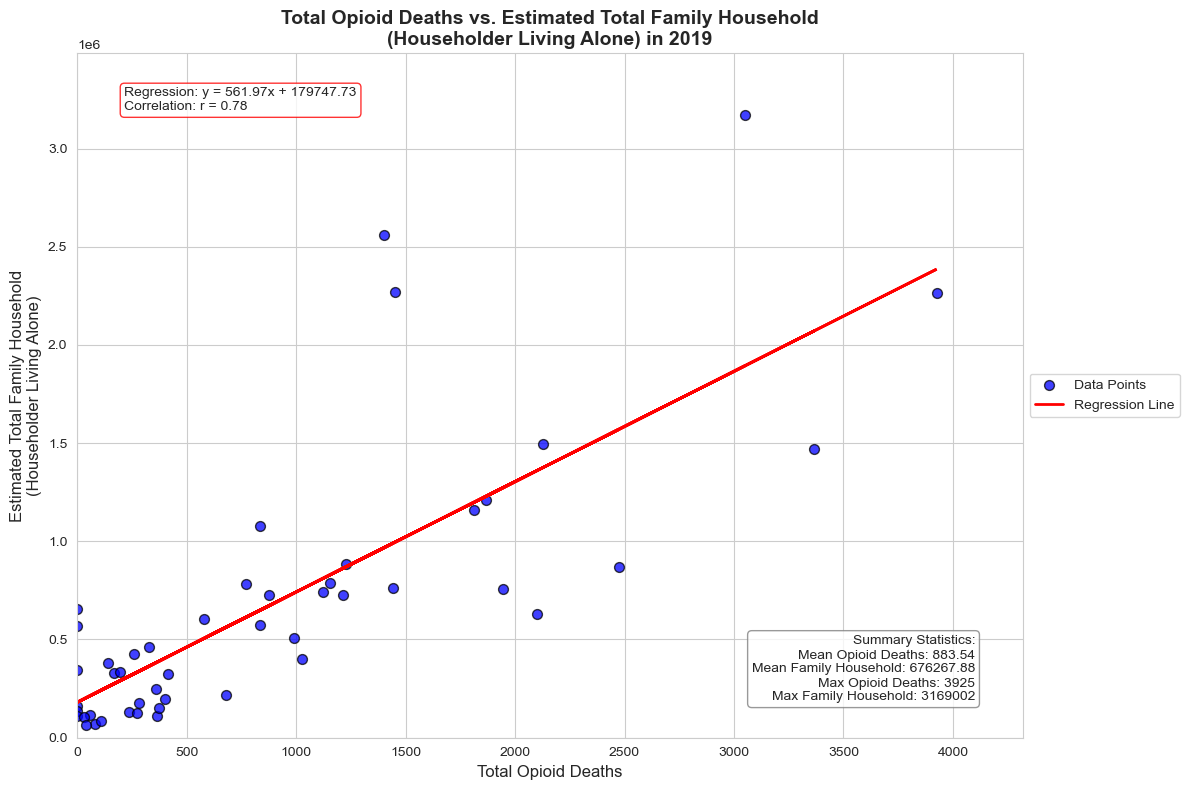


Detailed Summary Statistics for 2019:
       Total Opioid Deaths  \
count            48.000000   
mean            883.542048   
std             953.929746   
min               0.000000   
25%             160.891667   
50%             498.602273   
75%            1271.833333   
max            3925.333333   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        6.762679e+05           
std                                         6.906900e+05           
min                                         6.393900e+04           
25%                                         1.745992e+05           
50%                                         4.868930e+05           
75%                                         7.830232e+05           
max                                         3.169002e+06           




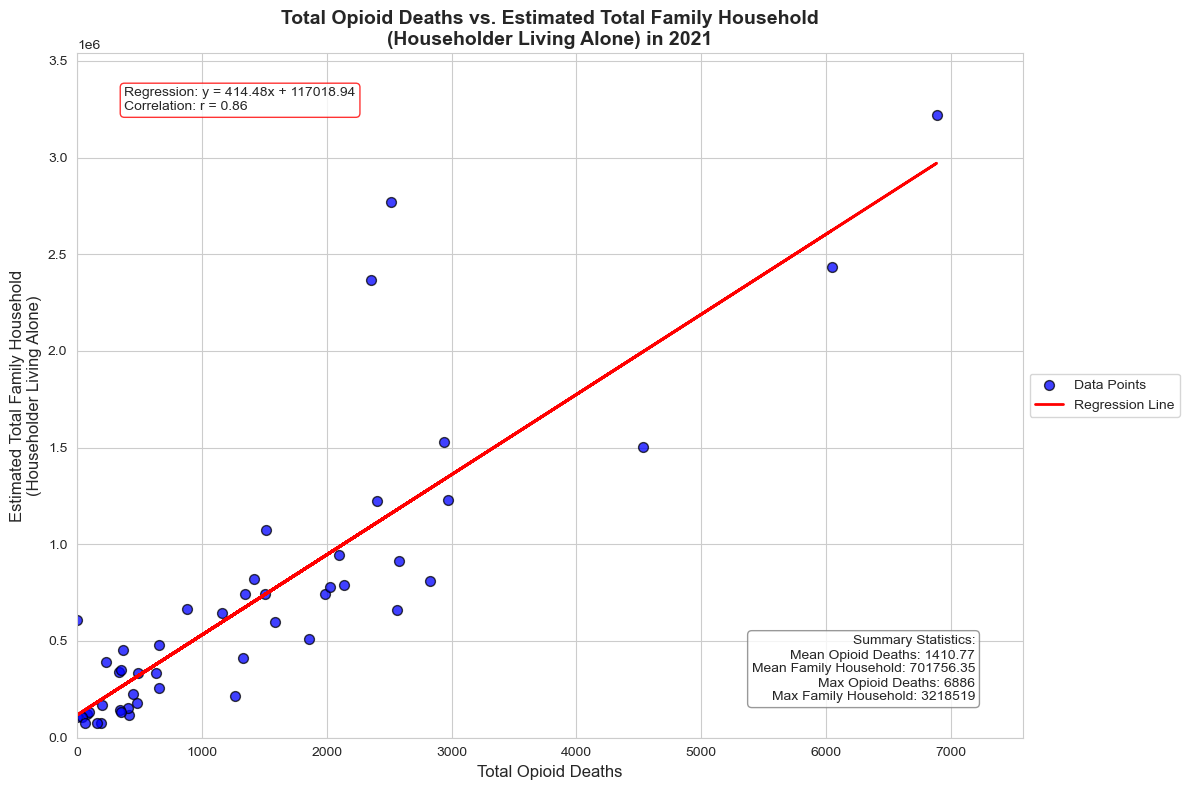


Detailed Summary Statistics for 2021:
       Total Opioid Deaths  \
count            48.000000   
mean           1410.772743   
std            1496.527759   
min               0.000000   
25%             349.104167   
50%            1017.625000   
75%            2106.187500   
max            6885.666667   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        7.017564e+05           
std                                         7.215318e+05           
min                                         7.508800e+04           
25%                                         1.750688e+05           
50%                                         4.944965e+05           
75%                                         8.108198e+05           
max                                         3.218519e+06           




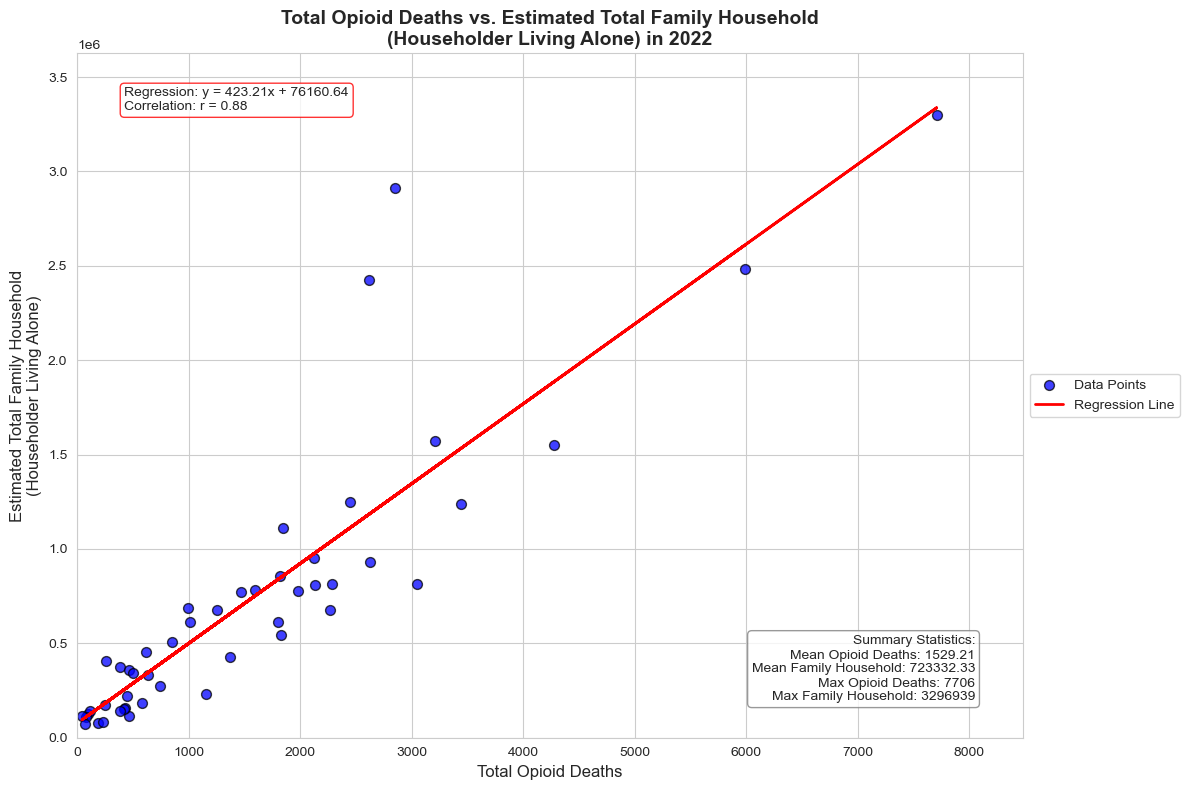


Detailed Summary Statistics for 2022:
       Total Opioid Deaths  \
count            48.000000   
mean           1529.211516   
std            1550.146827   
min              41.750000   
25%             424.583333   
50%            1085.305556   
75%            2167.979167   
max            7705.583333   

       Estimated Total Family Household(Householder Living Alone)  
count                                       4.800000e+01           
mean                                        7.233323e+05           
std                                         7.423948e+05           
min                                         7.405400e+04           
25%                                         1.795890e+05           
50%                                         5.241070e+05           
75%                                         8.261055e+05           
max                                         3.296939e+06           




In [7]:
import import_ipynb
import Family_Size_Notebook

importing Jupyter notebook from Income_Notebook.ipynb


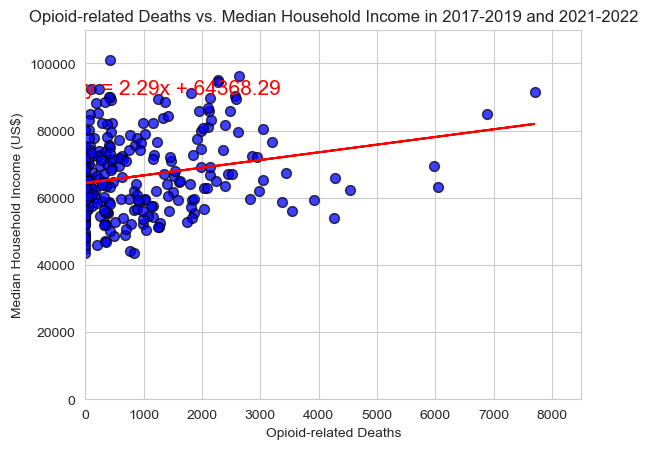

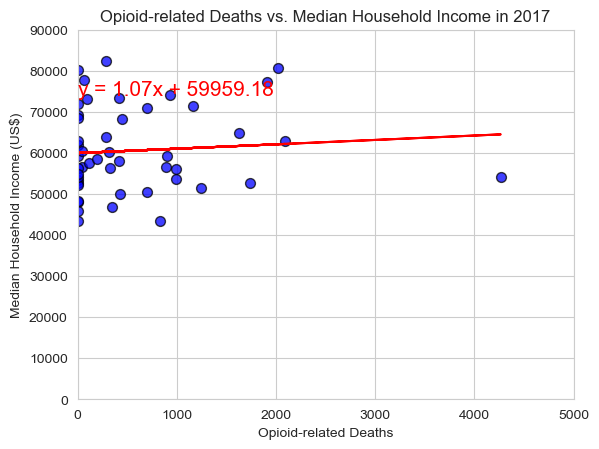

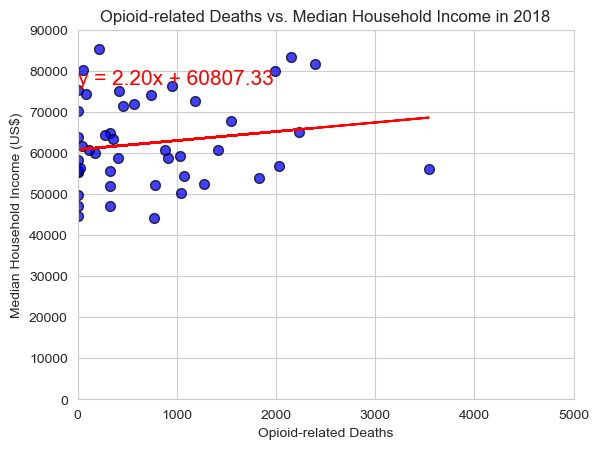

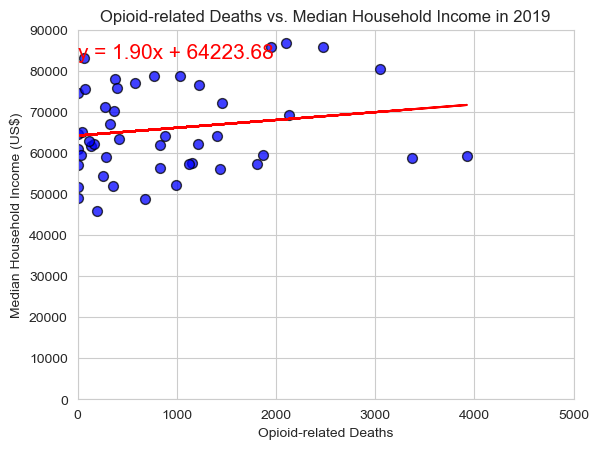

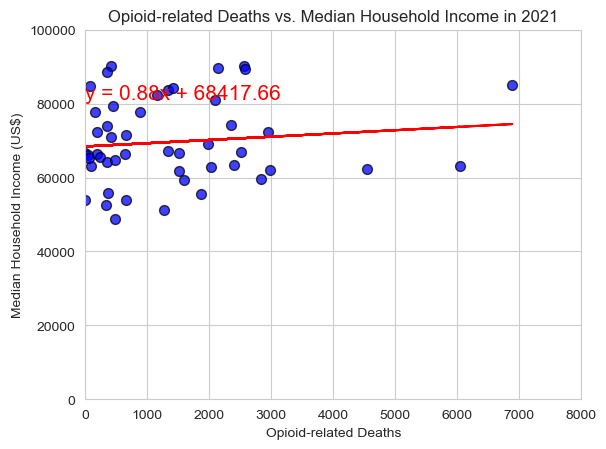

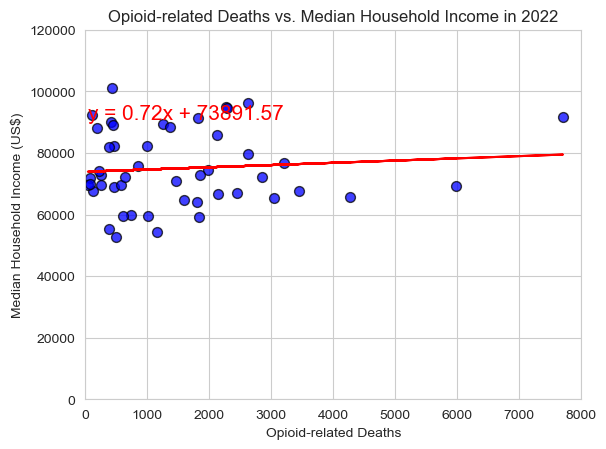

T-Test: t-statistic = 0.9579628745336706, p-value = 0.3390535844206676
ANOVA: F-statistic = 0.9176928689848125, p-value = 0.3390535844206731


In [8]:
import import_ipynb
import Income_Notebook